# Text Simplification Dataset Analysis

This notebook analyzes a text simplification dataset with three complexity levels:
- **Elementary**: Simplified text for basic readers
- **Intermediate**: Medium complexity text
- **Advanced**: Complex/original text

The dataset contains parallel texts at different complexity levels, making it ideal for text simplification research.

In [3]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 894.6 kB/s eta 0:00:00 kB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.5 MB/s eta 0:00:00 MB/s eta 0:00:01:01

[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# Essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from textstat import flesch_reading_ease, flesch_kincaid_grade, automated_readability_index
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import ast
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Initial Exploration

In [4]:
# Load the combined dataset
df = pd.read_csv('Kaggle Archive/all_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (189, 3)

Columns: ['Elementary', 'Intermediate', 'Advanced']

First few rows:


,Elementary,Intermediate,Advanced
0,"['When you see the word Amazon, what’s\nthe fi...","['When you see the word Amazon, what’s\nthe fi...","['When you see the word Amazon, what’s the\nfi..."
1,"['To tourists, Amsterdam still seems very libe...","['To tourists, Amsterdam still seems very libe...","['Amsterdam still looks liberal to tourists, w..."
2,"['Anitta, a music star from Brazil, has millio...","['Brazil’s latest funk sensation, Anitta, has ...","['Brazil’s latest funk sensation, Anitta, has ..."
3,['Google has made maps of the world’s\nhighest...,"['It has mapped the world’s highest peaks, the...","['It has charted the world’s highest peaks, th..."
4,['The auction of a Banksy painting that\ndisap...,['The controversial auction of a Banksy mural\...,['The controversial auction of a Banksy mural ...


In [5]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

print("\nBasic statistics:")
print(df.describe())

Missing values per column:
Elementary      0
Intermediate    0
Advanced        0
dtype: int64

Data types:
Elementary      object
Intermediate    object
Advanced        object
dtype: object

Basic statistics:
                                               Elementary  \
count                                                 189   
unique                                                189   
top     ['When you see the word Amazon, what’s\nthe fi...   
freq                                                    1   

                                             Intermediate  \
count                                                 189   
unique                                                189   
top     ['When you see the word Amazon, what’s\nthe fi...   
freq                                                    1   

                                                 Advanced  
count                                                 189  
unique                                                189  

## 2. Data Preprocessing and Text Parsing

In [6]:
def safe_eval(text):
    """Safely evaluate string representation of lists"""
    if pd.isna(text):
        return []
    try:
        # Try to evaluate as Python literal
        return ast.literal_eval(text)
    except (ValueError, SyntaxError):
        # If that fails, treat as a single string
        return [str(text)]

# Parse the text columns (they appear to be stored as string representations of lists)
df_parsed = df.copy()
for col in ['Elementary', 'Intermediate', 'Advanced']:
    df_parsed[col] = df_parsed[col].apply(safe_eval)

print("Sample parsed data:")
for i, row in df_parsed.head(2).iterrows():
    print(f"\n--- Article {i+1} ---")
    print(f"Elementary sentences: {len(row['Elementary'])}")
    print(f"Intermediate sentences: {len(row['Intermediate'])}")
    print(f"Advanced sentences: {len(row['Advanced'])}")
    
    if row['Elementary']:
        print(f"\nFirst Elementary sentence: {row['Elementary'][0][:100]}...")
    if row['Advanced']:
        print(f"First Advanced sentence: {row['Advanced'][0][:100]}...")

Sample parsed data:

--- Article 1 ---
Elementary sentences: 1
Intermediate sentences: 1
Advanced sentences: 15

First Elementary sentence: ['When you see the word Amazon, what’s\nthe first thing you think of – the world’s\nbiggest forest, ...
First Advanced sentence: When you see the word Amazon, what’s the
first thing that springs to mind – the world’s
biggest fore...

--- Article 2 ---
Elementary sentences: 7
Intermediate sentences: 7
Advanced sentences: 7

First Elementary sentence: To tourists, Amsterdam still seems very liberal. Recently the city’s Mayor told them that the coffee...
First Advanced sentence: Amsterdam still looks liberal to tourists, who were recently assured by the Labour Mayor that the ci...


In [7]:
# Create a flattened dataset with sentence pairs
sentence_data = []

for idx, row in df_parsed.iterrows():
    elementary = row['Elementary']
    intermediate = row['Intermediate']
    advanced = row['Advanced']
    
    # Get the maximum length to align sentences
    max_len = max(len(elementary), len(intermediate), len(advanced))
    
    for i in range(max_len):
        elem_sent = elementary[i] if i < len(elementary) else None
        inter_sent = intermediate[i] if i < len(intermediate) else None
        adv_sent = advanced[i] if i < len(advanced) else None
        
        # Only add if at least elementary and advanced exist
        if elem_sent and adv_sent:
            sentence_data.append({
                'article_id': idx,
                'sentence_id': i,
                'elementary': elem_sent,
                'intermediate': inter_sent,
                'advanced': adv_sent
            })

# Create DataFrame with sentence pairs
sentences_df = pd.DataFrame(sentence_data)
print(f"Total sentence pairs: {len(sentences_df)}")
sentences_df.head()

Total sentence pairs: 468


,article_id,sentence_id,elementary,intermediate,advanced
0,0,0,"['When you see the word Amazon, what’s\nthe fi...","['When you see the word Amazon, what’s\nthe fi...","When you see the word Amazon, what’s the\nfirs..."
1,1,0,"To tourists, Amsterdam still seems very libera...","To tourists, Amsterdam still seems very libera...","Amsterdam still looks liberal to tourists, who..."
2,1,1,"The Mayor, Eberhard van der Laan, says his new...","The Mayor, Eberhard van der Laan, says his con...","The Mayor, Eberhard van der Laan, insists his ..."
3,1,2,"Bartho Boer, a spokesman for the Mayor, says t...","Bartho Boer, a spokesman for the Mayor, says t...","But Bartho Boer, a spokesman for the Mayor, de..."
4,1,3,People found guilty of violent harassment will...,People found guilty of causing “extreme havoc”...,Those deemed guilty of causing “extreme havoc”...


## 3. Text Complexity Analysis

In [8]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

try:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('stopwords')
except Exception as e:
    print(f"Warning: NLTK download failed: {e}")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/darylmurenzi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/darylmurenzi/nltk_data...


✓ NLTK data downloaded successfully


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/darylmurenzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def simple_sentence_tokenize(text):
    """Simple sentence tokenizer that doesn't rely on NLTK"""
    if not text:
        return []
    # Split on sentence ending punctuation
    sentences = re.split(r'[.!?]+', text)
    # Remove empty strings and strip whitespace
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

def simple_word_tokenize(text):
    """Simple word tokenizer that doesn't rely on NLTK"""
    if not text:
        return []
    # Split on whitespace and punctuation, keep only alphabetic words
    words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    return words

def safe_textstat_score(text, metric_func):
    """Safely calculate textstat metrics with error handling"""
    try:
        if not text or pd.isna(text) or len(text.strip()) == 0:
            return 0
        # Some textstat functions fail on very short texts
        if len(text.strip()) < 10:
            return 0
        return metric_func(text)
    except:
        return 0

def calculate_text_metrics(text):
    """Calculate various text complexity metrics with robust error handling"""
    
    # Handle empty or NaN input
    if not text or pd.isna(text):
        return {
            'word_count': 0,
            'sentence_count': 0,
            'avg_word_length': 0,
            'flesch_score': 0,
            'flesch_grade': 0,
            'automated_readability': 0
        }
    
    # Convert to string if it's not already
    text = str(text)
    
    # Basic tokenization without NLTK dependencies
    try:
        words = simple_word_tokenize(text)
        sentences = simple_sentence_tokenize(text)
    except:
        # Fallback: very simple tokenization
        words = text.lower().split()
        words = [re.sub(r'[^a-zA-Z]', '', word) for word in words]
        words = [word for word in words if word]
        sentences = text.split('.')
        sentences = [s.strip() for s in sentences if s.strip()]
    
    # Calculate basic metrics
    word_count = len(words)
    sentence_count = len(sentences) if sentences else 1  # Avoid division by zero
    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    
    # Calculate readability scores with error handling
    try:
        flesch_score = safe_textstat_score(text, flesch_reading_ease)
        flesch_grade = safe_textstat_score(text, flesch_kincaid_grade)
        automated_readability = safe_textstat_score(text, automated_readability_index)
    except ImportError:
        # If textstat is not available, use simple approximations
        if sentence_count > 0 and word_count > 0:
            avg_sentence_length = word_count / sentence_count
            # Simple syllable approximation: count vowel groups
            total_syllables = sum([max(1, len(re.findall(r'[aeiouAEIOU]', word))) for word in words])
            avg_syllables_per_word = total_syllables / word_count if word_count > 0 else 0
            
            flesch_score = max(0, min(100, 206.835 - 1.015 * avg_sentence_length - 84.6 * avg_syllables_per_word))
            flesch_grade = max(0, 0.39 * avg_sentence_length + 11.8 * avg_syllables_per_word - 15.59)
            automated_readability = max(0, 4.71 * avg_syllables_per_word + 0.5 * avg_sentence_length - 21.43)
        else:
            flesch_score = 0
            flesch_grade = 0
            automated_readability = 0
    except Exception as e:
        # If any other error occurs, set to 0
        flesch_score = 0
        flesch_grade = 0
        automated_readability = 0
    
    return {
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': round(avg_word_length, 2),
        'flesch_score': round(flesch_score, 2),
        'flesch_grade': round(flesch_grade, 2),
        'automated_readability': round(automated_readability, 2)
    }

# Calculate metrics for each complexity level
print("Calculating text complexity metrics...")
for level in ['elementary', 'intermediate', 'advanced']:
    print(f"Processing {level} level...")
    try:
        metrics = sentences_df[level].apply(calculate_text_metrics)
        
        # Convert to DataFrame and add to main dataframe
        metrics_df = pd.DataFrame(metrics.tolist())
        for col in metrics_df.columns:
            sentences_df[f'{level}_{col}'] = metrics_df[col]
        print(f"  ✓ {level} metrics calculated successfully")
    except Exception as e:
        print(f"  ✗ Error calculating {level} metrics: {e}")
        # Add empty columns if calculation fails
        for metric in ['word_count', 'sentence_count', 'avg_word_length', 'flesch_score', 'flesch_grade', 'automated_readability']:
            sentences_df[f'{level}_{metric}'] = 0

print("\nMetrics calculation complete!")
print(f"Dataset now has {sentences_df.shape[1]} columns")
sentences_df.head()

Calculating text complexity metrics...
Processing elementary level...
  ✓ elementary metrics calculated successfully
Processing intermediate level...
  ✓ intermediate metrics calculated successfully
Processing advanced level...
  ✓ advanced metrics calculated successfully

Metrics calculation complete!
Dataset now has 23 columns


,article_id,sentence_id,elementary,intermediate,advanced,elementary_word_count,elementary_sentence_count,elementary_avg_word_length,elementary_flesch_score,elementary_flesch_grade,...,intermediate_avg_word_length,intermediate_flesch_score,intermediate_flesch_grade,intermediate_automated_readability,advanced_word_count,advanced_sentence_count,advanced_avg_word_length,advanced_flesch_score,advanced_flesch_grade,advanced_automated_readability
0,0,0,"['When you see the word Amazon, what’s\nthe fi...","['When you see the word Amazon, what’s\nthe fi...","When you see the word Amazon, what’s the\nfirs...",426,34,4.84,34.71,12.20,...,4.97,30.22,13.44,17.33,35,1,4.49,50.29,14.44,17.14
1,1,0,"To tourists, Amsterdam still seems very libera...","To tourists, Amsterdam still seems very libera...","Amsterdam still looks liberal to tourists, who...",68,3,4.51,53.76,11.23,...,5.05,46.84,11.12,13.89,56,2,5.25,36.86,14.83,18.32
2,1,1,"The Mayor, Eberhard van der Laan, says his new...","The Mayor, Eberhard van der Laan, says his con...","The Mayor, Eberhard van der Laan, insists his ...",66,3,4.70,60.17,10.33,...,4.90,34.97,17.20,20.93,69,2,5.12,30.82,17.53,21.35
3,1,2,"Bartho Boer, a spokesman for the Mayor, says t...","Bartho Boer, a spokesman for the Mayor, says t...","But Bartho Boer, a spokesman for the Mayor, de...",96,5,4.20,64.85,8.98,...,4.35,57.10,10.26,9.70,104,5,4.45,54.76,10.79,10.59
4,1,3,People found guilty of violent harassment will...,People found guilty of causing “extreme havoc”...,Those deemed guilty of causing “extreme havoc”...,70,4,4.99,47.67,10.96,...,5.16,35.78,13.90,15.25,68,3,5.19,34.53,14.07,15.39


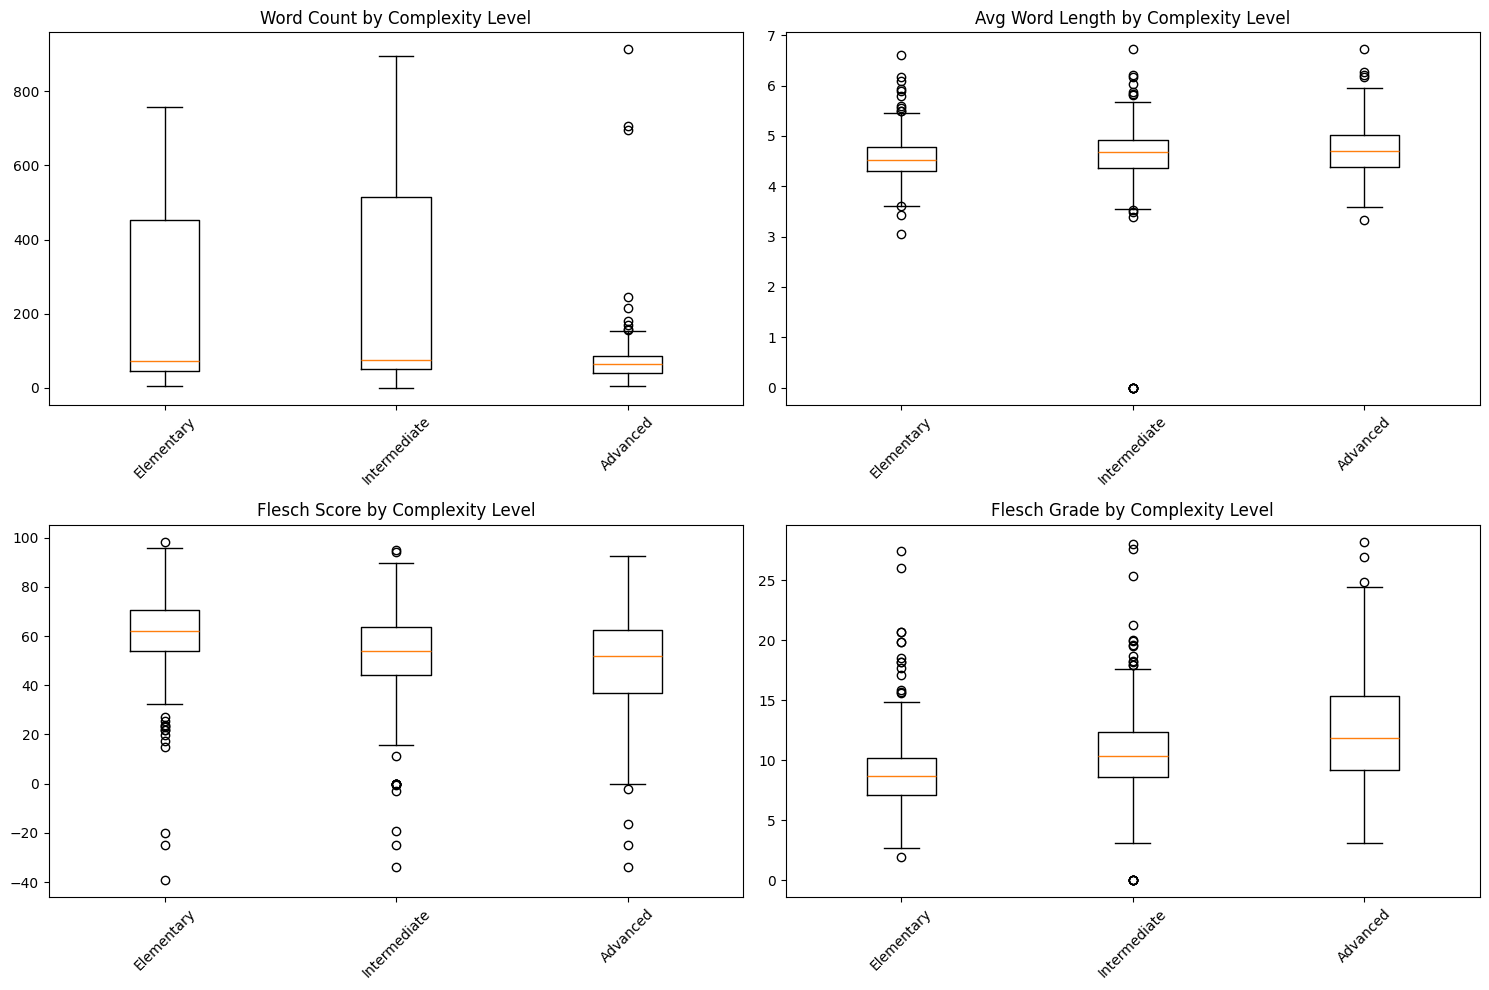


Summary Statistics by Complexity Level:

Word Count:
  Elementary: 212.58 (±230.45)
  Intermediate: 228.68 (±279.94)
  Advanced: 70.81 (±65.64)

Avg Word Length:
  Elementary: 4.55 (±0.42)
  Intermediate: 4.61 (±0.72)
  Advanced: 4.71 (±0.48)

Flesch Score:
  Elementary: 60.98 (±14.92)
  Intermediate: 52.71 (±17.37)
  Advanced: 49.58 (±18.54)

Flesch Grade:
  Elementary: 8.95 (±2.91)
  Intermediate: 10.62 (±3.57)
  Advanced: 12.41 (±4.28)


In [10]:
# Compare complexity metrics across levels
metrics_to_compare = ['word_count', 'avg_word_length', 'flesch_score', 'flesch_grade']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, metric in enumerate(metrics_to_compare):
    data_to_plot = []
    labels = []
    
    for level in ['elementary', 'intermediate', 'advanced']:
        col_name = f'{level}_{metric}'
        if col_name in sentences_df.columns:
            data_to_plot.append(sentences_df[col_name].dropna())
            labels.append(level.capitalize())
    
    if data_to_plot:
        axes[i].boxplot(data_to_plot, labels=labels)
        axes[i].set_title(f'{metric.replace("_", " ").title()} by Complexity Level')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics by Complexity Level:")
for metric in metrics_to_compare:
    print(f"\n{metric.replace('_', ' ').title()}:")
    for level in ['elementary', 'intermediate', 'advanced']:
        col_name = f'{level}_{metric}'
        if col_name in sentences_df.columns:
            mean_val = sentences_df[col_name].mean()
            std_val = sentences_df[col_name].std()
            print(f"  {level.capitalize()}: {mean_val:.2f} (±{std_val:.2f})")

## 4. Text Simplification Examples

In [11]:
# Show examples of text simplification
def show_simplification_examples(df, n=5):
    """Display examples of text at different complexity levels"""
    
    # Filter out rows with missing data
    complete_rows = df.dropna(subset=['elementary', 'advanced'])
    
    # Select random examples
    examples = complete_rows.sample(n=min(n, len(complete_rows)))
    
    for i, (idx, row) in enumerate(examples.iterrows()):
        print(f"\n{'='*60}")
        print(f"EXAMPLE {i+1}")
        print(f"{'='*60}")
        
        print("\n🔴 ADVANCED (Original):")
        print(f"{row['advanced']}")
        
        if pd.notna(row['intermediate']):
            print("\n🟡 INTERMEDIATE:")
            print(f"{row['intermediate']}")
        
        print("\n🟢 ELEMENTARY (Simplified):")
        print(f"{row['elementary']}")
        
        # Show metrics
        print("\n📊 COMPLEXITY METRICS:")
        for level in ['advanced', 'elementary']:
            if f'{level}_word_count' in df.columns:
                wc = row[f'{level}_word_count']
                awl = row[f'{level}_avg_word_length']
                flesch = row[f'{level}_flesch_score']
                print(f"  {level.upper()}: {wc} words, {awl:.1f} avg word length, {flesch:.1f} Flesch score")

show_simplification_examples(sentences_df, n=3)


EXAMPLE 1

🔴 ADVANCED (Original):
He is the star of one of the world’s longest running
and most successful film series, with 23 movies and
more than $6bn amassed at the global box office,
but James Bond shows no signs of slowing down.
In fact, the Bond brand is stronger than ever, after
the record-breaking performance of Skyfall, which
became the biggest ever film at the UK box office
on its release in 2012 and, with its total earnings of
$1.1bn, currently stands in ninth place of all-time
largest earners.

🟡 INTERMEDIATE:
['James Bond films are one of the world’s longest\nrunning and most successful film series, with 23\nmovies and more than $6bn earned at box offices\naround the world. But James Bond shows no signs\nof slowing down. In fact, Bond is more popular\nthan ever, after the record-breaking performance of\nSkyfall, which became the biggest ever film at the\nUK box office in 2012, earning a total of $1.1bn.', 'For this reason, there was a lot of interest\nsurrounding the ann

## 5. Vocabulary Analysis

In [12]:
def analyze_vocabulary(texts, level_name):
    """Analyze vocabulary usage in texts"""
    all_words = []
    stop_words = set(stopwords.words('english'))
    
    for text in texts:
        if pd.notna(text):
            words = word_tokenize(text.lower())
            # Filter out punctuation and stop words
            words = [word for word in words if word.isalpha() and word not in stop_words]
            all_words.extend(words)
    
    word_freq = Counter(all_words)
    unique_words = len(word_freq)
    total_words = len(all_words)
    
    print(f"\n{level_name.upper()} VOCABULARY:")
    print(f"  Total words: {total_words:,}")
    print(f"  Unique words: {unique_words:,}")
    print(f"  Vocabulary richness: {unique_words/total_words:.3f}")
    print(f"  Top 10 words: {word_freq.most_common(10)}")
    
    return word_freq

# Analyze vocabulary for each level
vocab_stats = {}
for level in ['elementary', 'intermediate', 'advanced']:
    vocab_stats[level] = analyze_vocabulary(sentences_df[level], level)


ELEMENTARY VOCABULARY:
  Total words: 46,338
  Unique words: 8,019
  Vocabulary richness: 0.173
  Top 10 words: [('said', 743), ('people', 706), ('nan', 537), ('says', 328), ('also', 255), ('one', 251), ('new', 199), ('world', 194), ('years', 186), ('would', 181)]

INTERMEDIATE VOCABULARY:
  Total words: 50,349
  Unique words: 10,026
  Vocabulary richness: 0.199
  Top 10 words: [('said', 670), ('people', 439), ('one', 284), ('nan', 257), ('says', 249), ('would', 210), ('also', 203), ('world', 198), ('new', 193), ('years', 171)]

ADVANCED VOCABULARY:
  Total words: 17,472
  Unique words: 6,386
  Vocabulary richness: 0.365
  Top 10 words: [('said', 147), ('one', 97), ('people', 90), ('world', 76), ('would', 72), ('new', 70), ('also', 53), ('says', 47), ('could', 47), ('like', 47)]


In [13]:
# Compare vocabulary overlap between levels
def vocabulary_overlap(vocab1, vocab2, name1, name2):
    """Calculate vocabulary overlap between two levels"""
    words1 = set(vocab1.keys())
    words2 = set(vocab2.keys())
    
    overlap = words1.intersection(words2)
    only_in_1 = words1 - words2
    only_in_2 = words2 - words1
    
    print(f"\nVOCABULARY OVERLAP: {name1.upper()} vs {name2.upper()}")
    print(f"  Shared words: {len(overlap)} ({len(overlap)/len(words1.union(words2)):.1%})")
    print(f"  Only in {name1}: {len(only_in_1)}")
    print(f"  Only in {name2}: {len(only_in_2)}")
    
    return overlap, only_in_1, only_in_2

# Compare elementary vs advanced
if 'elementary' in vocab_stats and 'advanced' in vocab_stats:
    overlap_ea, only_elem, only_adv = vocabulary_overlap(
        vocab_stats['elementary'], 
        vocab_stats['advanced'], 
        'elementary', 
        'advanced'
    )
    
    print(f"\nWords unique to ADVANCED (sample): {list(only_adv)[:20]}")
    print(f"Words unique to ELEMENTARY (sample): {list(only_elem)[:20]}")


VOCABULARY OVERLAP: ELEMENTARY vs ADVANCED
  Shared words: 4372 (43.6%)
  Only in elementary: 3647
  Only in advanced: 2014

Words unique to ADVANCED (sample): ['guarded', 'fraught', 'skinõs', 'appearance', 'statue', 'grins', 'technique', 'smelling', 'throws', 'chances', 'rr', 'otherwise', 'òprofoundó', 'facing', 'convey', 'drawing', 'orid', 'contemplative', 'puentes', 'shortcomings']
Words unique to ELEMENTARY (sample): ['drinkers', 'meantime', 'performing', 'òwithout', 'chapron', 'awan', 'phantom', 'saturdays', 'assurance', 'gums', 'rstó', 'employing', 'merchandise', 'panic', 'nish', 'quietly', 'renting', 'calcutta', 'innovative', 'unsuccessful']


## 6. Dataset Preparation for Machine Learning

In [14]:
# Prepare datasets for different simplification tasks

# 1. Advanced to Elementary simplification
adv_to_elem = sentences_df[['advanced', 'elementary']].dropna()
adv_to_elem.columns = ['source', 'target']
adv_to_elem['task'] = 'advanced_to_elementary'

# 2. Advanced to Intermediate simplification
adv_to_inter = sentences_df[['advanced', 'intermediate']].dropna()
adv_to_inter.columns = ['source', 'target']
adv_to_inter['task'] = 'advanced_to_intermediate'

# 3. Intermediate to Elementary simplification
inter_to_elem = sentences_df[['intermediate', 'elementary']].dropna()
inter_to_elem.columns = ['source', 'target']
inter_to_elem['task'] = 'intermediate_to_elementary'

# Combine all tasks
ml_dataset = pd.concat([adv_to_elem, adv_to_inter, inter_to_elem], ignore_index=True)

print(f"Machine Learning Dataset Summary:")
print(f"Total pairs: {len(ml_dataset)}")
print(f"\nBy task:")
print(ml_dataset['task'].value_counts())

# Save the ML dataset
ml_dataset.to_csv('text_simplification_ml_dataset.csv', index=False)
print(f"\nDataset saved as 'text_simplification_ml_dataset.csv'")

ml_dataset.head()

Machine Learning Dataset Summary:
Total pairs: 1390

By task:
task
advanced_to_elementary        468
advanced_to_intermediate      461
intermediate_to_elementary    461
Name: count, dtype: int64

Dataset saved as 'text_simplification_ml_dataset.csv'


,source,target,task
0,"When you see the word Amazon, what’s the\nfirs...","['When you see the word Amazon, what’s\nthe fi...",advanced_to_elementary
1,"Amsterdam still looks liberal to tourists, who...","To tourists, Amsterdam still seems very libera...",advanced_to_elementary
2,"The Mayor, Eberhard van der Laan, insists his ...","The Mayor, Eberhard van der Laan, says his new...",advanced_to_elementary
3,"But Bartho Boer, a spokesman for the Mayor, de...","Bartho Boer, a spokesman for the Mayor, says t...",advanced_to_elementary
4,Those deemed guilty of causing “extreme havoc”...,People found guilty of violent harassment will...,advanced_to_elementary


In [15]:
# Create train/validation/test splits
from sklearn.model_selection import train_test_split

def create_splits(df, test_size=0.2, val_size=0.1, random_state=42):
    """Create train/validation/test splits"""
    
    # First split: separate test set
    train_val, test = train_test_split(
        df, test_size=test_size, random_state=random_state, stratify=df['task']
    )
    
    # Second split: separate validation from training
    val_size_adjusted = val_size / (1 - test_size)  # Adjust validation size
    train, val = train_test_split(
        train_val, test_size=val_size_adjusted, random_state=random_state, stratify=train_val['task']
    )
    
    return train, val, test

# Create splits for each task
splits = {}

for task in ml_dataset['task'].unique():
    task_data = ml_dataset[ml_dataset['task'] == task].copy()
    
    if len(task_data) >= 10:  # Only split if we have enough data
        # For small datasets, just do train/test split
        train_data, test_data = train_test_split(
            task_data, test_size=0.2, random_state=42
        )
        
        # Use 10% of training data for validation
        if len(train_data) >= 10:
            train_data, val_data = train_test_split(
                train_data, test_size=0.125, random_state=42  # 0.125 of 0.8 = 0.1 of total
            )
        else:
            val_data = train_data.sample(n=min(2, len(train_data)//2), random_state=42)
            train_data = train_data.drop(val_data.index)
        
        splits[task] = {
            'train': train_data,
            'val': val_data,
            'test': test_data
        }
        
        print(f"\n{task.upper()} SPLITS:")
        print(f"  Train: {len(train_data)} samples")
        print(f"  Validation: {len(val_data)} samples")
        print(f"  Test: {len(test_data)} samples")
        
        # Save splits
        train_data.to_csv(f'{task}_train.csv', index=False)
        val_data.to_csv(f'{task}_val.csv', index=False)
        test_data.to_csv(f'{task}_test.csv', index=False)

print("\nDataset splits saved successfully!")


ADVANCED_TO_ELEMENTARY SPLITS:
  Train: 327 samples
  Validation: 47 samples
  Test: 94 samples

ADVANCED_TO_INTERMEDIATE SPLITS:
  Train: 322 samples
  Validation: 46 samples
  Test: 93 samples

INTERMEDIATE_TO_ELEMENTARY SPLITS:
  Train: 322 samples
  Validation: 46 samples
  Test: 93 samples

Dataset splits saved successfully!


## 7. Next Steps and Recommendations

Based on the analysis of your text simplification dataset, here are some recommendations for your NLP project:

### Dataset Strengths:
- **Parallel texts** at three complexity levels (Elementary, Intermediate, Advanced)
- **Real-world content** from news articles and various topics
- **Measurable complexity differences** in readability scores, vocabulary, and sentence structure

### Potential Approaches:

1. **Seq2Seq Models**: Train transformer models (T5, BART, GPT) for text simplification
2. **Multi-level Simplification**: Train models for different simplification levels
3. **Readability Prediction**: Build models to predict text complexity
4. **Rule-based Simplification**: Develop rules based on vocabulary and syntax analysis

### Recommended Models to Try:
- **T5**: "Summarize: [complex text]" → simplified version
- **BART**: Fine-tune for text simplification
- **PEGASUS**: Originally for summarization, adaptable for simplification
- **GPT models**: With appropriate prompting strategies

### Evaluation Metrics:
- **BLEU/ROUGE scores**: Compare generated text with reference simplifications
- **Readability scores**: Flesch-Kincaid, ARI to measure complexity reduction
- **Semantic similarity**: Ensure meaning preservation
- **Human evaluation**: Assess fluency and adequacy

### Files Created:
- `text_simplification_ml_dataset.csv`: Combined dataset for ML
- `*_train.csv`, `*_val.csv`, `*_test.csv`: Train/validation/test splits for each task

In [16]:
# Final dataset summary
print("📊 FINAL DATASET SUMMARY")
print("=" * 50)
print(f"📄 Total articles: {len(df_parsed)}")
print(f"📝 Total sentence pairs: {len(sentences_df)}")
print(f"🤖 ML dataset pairs: {len(ml_dataset)}")

print(f"\n📈 COMPLEXITY ANALYSIS:")
for level in ['elementary', 'intermediate', 'advanced']:
    if f'{level}_flesch_score' in sentences_df.columns:
        avg_flesch = sentences_df[f'{level}_flesch_score'].mean()
        avg_words = sentences_df[f'{level}_word_count'].mean()
        print(f"  {level.capitalize()}: {avg_flesch:.1f} Flesch score, {avg_words:.1f} avg words")

print(f"\n✅ READY FOR:")
print("  • Text simplification model training")
print("  • Readability assessment")
print("  • Vocabulary analysis")
print("  • Multi-level simplification research")

print(f"\n📁 FILES CREATED:")
import os
files_created = [
    'text_simplification_ml_dataset.csv',
    'advanced_to_elementary_train.csv',
    'advanced_to_elementary_val.csv', 
    'advanced_to_elementary_test.csv',
    'advanced_to_intermediate_train.csv',
    'advanced_to_intermediate_val.csv',
    'advanced_to_intermediate_test.csv',
    'intermediate_to_elementary_train.csv',
    'intermediate_to_elementary_val.csv',
    'intermediate_to_elementary_test.csv'
]

for file in files_created:
    if os.path.exists(file):
        print(f"  ✓ {file}")

📊 FINAL DATASET SUMMARY
📄 Total articles: 189
📝 Total sentence pairs: 468
🤖 ML dataset pairs: 1390

📈 COMPLEXITY ANALYSIS:
  Elementary: 61.0 Flesch score, 212.6 avg words
  Intermediate: 52.7 Flesch score, 228.7 avg words
  Advanced: 49.6 Flesch score, 70.8 avg words

✅ READY FOR:
  • Text simplification model training
  • Readability assessment
  • Vocabulary analysis
  • Multi-level simplification research

📁 FILES CREATED:
  ✓ text_simplification_ml_dataset.csv
  ✓ advanced_to_elementary_train.csv
  ✓ advanced_to_elementary_val.csv
  ✓ advanced_to_elementary_test.csv
  ✓ advanced_to_intermediate_train.csv
  ✓ advanced_to_intermediate_val.csv
  ✓ advanced_to_intermediate_test.csv
  ✓ intermediate_to_elementary_train.csv
  ✓ intermediate_to_elementary_val.csv
  ✓ intermediate_to_elementary_test.csv
